# Dividing into groups using Segmentation

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats.stats import pearsonr  
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist


## K-Means Clustering

Let's look at a simple example before getting into K-meas clustering. 

We'll plot a scatter plot of height and weight of people and group the scatter based on the tshirt sizes

In [52]:
df = pd.read_csv('./Data/tshirt_sizes.csv')
print df[:10]

   Height  Weight Size
0     150      54    S
1     150      55    S
2     151      55    S
3     151      47    S
4     152      58    S
5     155      53    S
6     155      59    S
7     157      60    S
8     157      56    S
9     157      55    S


Now, let's plot the scatter plot between height and weight , and group them based on the shirt sizes.

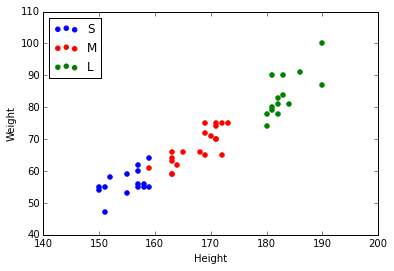

In [53]:
d_color = {
    "S": "b",
    "M": "r",
    "L": "g",
}
fig, ax = plt.subplots()
for size in ["S", "M", "L"]:
    color = d_color[size]
    df[df.Size == size].plot(kind='scatter', x='Height', y='Weight', label=size, ax=ax, color=color)
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc="upper left")

You can see that people who have sizes as small have height and Weight quite less which is colored in blue. Similarly for the other t-shirt sizes, the height and weight are grouped together around each other. 

In this case, we had the labels for the t-shirt sizes but we would require a machine learning algorithm which will automatically perform this for us. This is where an algorithm like K-means helps us

In [58]:
km = KMeans(3,init='k-means++', random_state=3425) # initialize
km.fit(df[['Height','Weight']])
df['SizePredict'] = km.predict(df[['Height','Weight']])
print pd.crosstab(df.Size
                  ,df.SizePredict
                  ,rownames = ['Size']
                  ,colnames = ['SizePredict'])

SizePredict   0   1   2
Size                   
L            13   0   1
M             0   6  14
S             0  15   0


We'll now map the clusters to the shirt sizes

In [55]:
c_map = {
    2: "M",
    1: "S",
    0: "L",
}

df['SizePredict'] = df['SizePredict'].map(c_map)
df['SizePredict'][:10]

0    S
1    S
2    S
3    S
4    S
5    S
6    S
7    S
8    S
9    S
Name: SizePredict, dtype: object

We define 3 clusters in the K-Means algorithm and then we input the height and weight to the kmeans algorithm. Post this we predict the buckets.

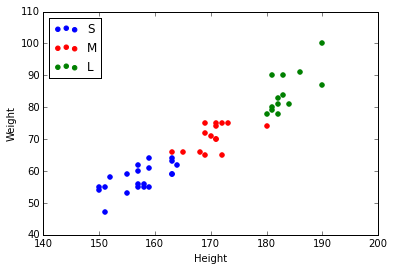

In [56]:
fig, ax = plt.subplots()
for size in ["S", "M", "L"]:
    color = d_color[size]
    df[df.SizePredict == size].plot(kind='scatter', x='Height', y='Weight', label=size, ax=ax, color=color)
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc="upper left")

We can see from the plot that the K-means algorithm was able to group the people into appropriate buckets where the shirt sizes can be used to identify a bucket as unique. 

## K-Means Clustering with U.N Data

We have UN data on different countries of the world on the education to GDP.
<table><tr><th>country</th><td>Name of the country</td></tr>
<tr><th>region</th><td>Continent the country belongs to</td></tr>
<tr><th>tfr</th><td>Total Fertility Rate</td></tr>
<tr><th>contraception</th><td>Percentage of people taking contraceptions</td></tr>
<tr><th>educationMale</th><td>Percentage of male population who are educated </td></tr>
<tr><th>educationFemale</th><td>Percentage of male population who are educated</td></tr>
<tr><th>lifeMale</th><td>Life Expectancy of Male</td></tr>
<tr><th>lifeFemale</th><td>Life Expectancy of Female</td></tr>
<tr><th>infantMortality</th><td>Infant Mortality Rate</td></tr>
<tr><th>GDPperCapita</th><td>GDP per capita</td></tr>
<tr><th>economicActivityMale</th><td>Males who generate income</td></tr>
<tr><th>economicActivityFemale</th><td>Females who generate income</td></tr>
<tr><th>illiteracyMale</th><td>Illiteracy rate in Male</td></tr>
<tr><th>illiteracyFemale</th><td>Illiteracy rate in Female</td></tr>
</table>

In [96]:
df = pd.read_csv('./Data/UN.csv')

print('----')

print('Individual columns - Python data types')
[(col, type(df[col][0])) for col in df.columns] 

----
Individual columns - Python data types


[('country', str),
 ('region', str),
 ('tfr', numpy.float64),
 ('contraception', numpy.float64),
 ('educationMale', numpy.float64),
 ('educationFemale', numpy.float64),
 ('lifeMale', numpy.float64),
 ('lifeFemale', numpy.float64),
 ('infantMortality', numpy.float64),
 ('GDPperCapita', numpy.float64),
 ('economicActivityMale', numpy.float64),
 ('economicActivityFemale', numpy.float64),
 ('illiteracyMale', numpy.float64),
 ('illiteracyFemale', numpy.float64)]

Let's see the fill rate of the columns 

In [97]:
print('Percentage of the values complete in the columns')
df.count(0)/df.shape[0] * 100

Percentage of the values complete in the columns


country                   100.000000
region                    100.000000
tfr                        95.169082
contraception              69.565217
educationMale              36.714976
educationFemale            36.714976
lifeMale                   94.685990
lifeFemale                 94.685990
infantMortality            97.101449
GDPperCapita               95.169082
economicActivityMale       79.710145
economicActivityFemale     79.710145
illiteracyMale             77.294686
illiteracyFemale           77.294686
dtype: float64

We can see that education columns don't have a good file rate followed by contraception.

The columns with a good fill rate is life expectancy of Male and Female, infant mortality and GDPperCapita. With these columns we'll be losing out only on few countries where as if we include other columns, we'll be losing out on a lot of countries

There should be a clustering influence based on the life expectancy of male and female, infant mortality rate based on the GDP of the country.

In [98]:
df = df[['lifeMale', 'lifeFemale', 'infantMortality', 'GDPperCapita']]

df = df.dropna(how='any')

### Determining the number of clusters

Before applying the K-means algorithm. We would like to know how many are the ideal clusters on the data.

In [67]:
K = range(1,10)

# scipy.cluster.vq.kmeans
k_clusters = [kmeans(df.values,k) for k in K] # apply kmeans 1 to 10
k_clusters[:3]

[(array([[   63.52606383,    68.30904255,    44.30851064,  5890.59574468]]),
  6534.9809626620172),
 (array([[  6.12851613e+01,   6.58683871e+01,   5.20903226e+01,
            2.25506452e+03],
         [  7.40515152e+01,   7.97727273e+01,   7.75757576e+00,
            2.29665758e+04]]), 2739.3341826915193),
 (array([[  6.01681159e+01,   6.46014493e+01,   5.63260870e+01,
            1.43936232e+03],
         [  7.43904762e+01,   8.03095238e+01,   6.57142857e+00,
            2.72491429e+04],
         [  7.16379310e+01,   7.72620690e+01,   1.44482759e+01,
            1.16057931e+04]]), 1868.849731735625)]

In the above code, we define number of clusters from 1 to 10. Using the scipy's k-mean, we compute the centroids and the distortion between the centroids and the observed values associated to that cluster 

In [68]:
euclidean_centroid = [cdist(df.values, centroid, 'euclidean') for (centroid,var) in k_clusters]
print '-----with 1 cluster------'
print euclidean_centroid[0][:5]

print '-----with 2 cluster------'
print euclidean_centroid[1][:5]


-----with 1 cluster------
[[ 3044.71049474]
 [ 5027.61602297]
 [ 4359.59802141]
 [ 5536.23755972]
 [ 2164.54439528]]
-----with 2 cluster------
[[   602.17773927  20119.15659136]
 [  1392.24942101  22103.5906339 ]
 [   724.14994321  21435.60949045]
 [  1901.57838551  22611.91552068]
 [  5800.02980003  14911.58351999]]


We take the centroids in each of the group of clusters and compute the euclidean distance from all the points in space to the centroids of the cluster using the cdist function in scipy.

You can see that the 1st cluster has only 1 column since it has only one cluster in it and the 2nd cluster has 2 columns as it has two clusters in it

In [69]:
distance = [np.min(D,axis=1) for D in euclidean_centroid]
print '-----with 1st cluster------'
print distance[0][:5]
print '-----with 2nd cluster------'
print distance[1][:5]

-----with 1st cluster------
[ 3044.71049474  5027.61602297  4359.59802141  5536.23755972  2164.54439528]
-----with 2nd cluster------
[  602.17773927  1392.24942101   724.14994321  1901.57838551  5800.02980003]


As we have the distance of each of the observed points from the different centroids, we find the minimum distance of each observed point from the closest centroid.

You can see above that the 1s  and 2nd clusters have single values to a centroid only now

We'll now compute the average of the sum of square of the distance.

In [70]:
avgWithinSumSquare = [sum(d)/df.values.shape[0] for d in distance]
avgWithinSumSquare

[6534.9809626620136,
 2807.8638101354968,
 1881.6887216763826,
 1438.7793254224125,
 1124.7641007615118,
 972.53807558001722,
 748.42564632860183,
 780.45196219473132,
 604.98921706893657]

Each of the value in the array is the average sum of square from having 1 cluster to a group of 10 clusters

We'll now plot the Elbow curve for K-Means clustering using this data

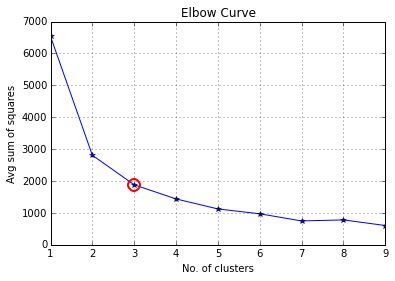

In [71]:
point_id = 2
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSumSquare, 'b*-')
ax.plot(K[point_id], avgWithinSumSquare[point_id], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('No. of clusters')
plt.ylabel('Avg sum of squares')
tt = plt.title('Elbow Curve')

This curve is really useful. It helps to know what would be the ideal number of clusters for K-Means. Here we can see that 3 number of clusters is ideal since the drop in Average sum of square is flattening out post it. 

These 3 clusters of countries should be Developed, Developing and under developed countries.

### Clustering the countries

We'll now apply the K-Means algorithm to cluster the countries together

In [99]:
km = KMeans(3, init='k-means++', random_state = 3425) # initialize
km.fit(df.values)
df['countrySegment'] = km.predict(df.values)
df[:5]

,lifeMale,lifeFemale,infantMortality,GDPperCapita,countrySegment
0,45.0,46.0,154,2848,1
1,68.0,74.0,32,863,1
2,67.5,70.3,44,1531,1
5,44.9,48.1,124,355,1
7,69.6,76.8,22,8055,0


Let's find the average GDP per capita for each country segment

In [100]:
df.groupby('countrySegment').GDPperCapita.mean()

countrySegment
0    13800.586207
1     1624.538462
2    29681.625000
Name: GDPperCapita, dtype: float64

We can see that cluster 2 has the highest average GDP per capita and we can assume these as Developed countries. Cluster 0 has the 2nd highest, we can assume these as the developing and finally cluster 1 has a very low average GDP per capita, we can assume this as under developed nations. 

In [101]:
clust_map = {
    0:'Developing',
    1:'Under Developed',
    2:'Developed'
}

df.countrySegment = df.countrySegment.map(clust_map)
df[:10]

,lifeMale,lifeFemale,infantMortality,GDPperCapita,countrySegment
0,45.0,46.0,154,2848,Under Developed
1,68.0,74.0,32,863,Under Developed
2,67.5,70.3,44,1531,Under Developed
5,44.9,48.1,124,355,Under Developed
7,69.6,76.8,22,8055,Developing
8,67.2,74.0,25,354,Under Developed
9,75.4,81.2,6,20046,Developing
10,73.7,80.1,6,29006,Developed
11,66.5,74.5,33,321,Under Developed
12,70.5,77.1,14,12545,Developing


Let's see the GDP vs infant mortality rate of the countries based on the cluster

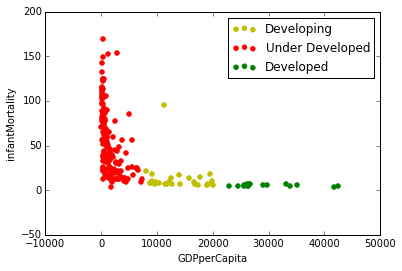

In [110]:
d_color = {
    'Developing':'y',
    'Under Developed':'r',
    'Developed':'g'
}

fig, ax = plt.subplots()
for clust in clust_map.values():
    color = d_color[clust]
    df[df.countrySegment == clust].plot(kind='scatter', x='GDPperCapita', y='infantMortality', label=clust, ax=ax, color=color)
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc="upper right")

We can see from the above graph that clearly when the GDP is low, the infant mortality rate is really high and as the GDP increases, the infant mortality rate decreases.

We can also clearly see that the countries in green are the under developed nations, the one in dark blue are the developing nations and the one in red are the Developed nations

Let's see the life expectancy of male with respect to the GDP

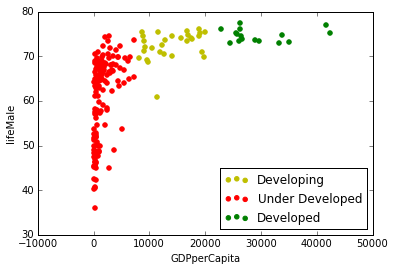

In [111]:
fig, ax = plt.subplots()
for clust in clust_map.values():
    color = d_color[clust]
    df[df.countrySegment == clust].plot(kind='scatter', x='GDPperCapita', y='lifeMale', label=clust, ax=ax, color=color)
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc="lower right")

We can see that the life expectancy of the male also increases with the GDP for the different kinds of nations.

Now for the life expectancy of female and GDP

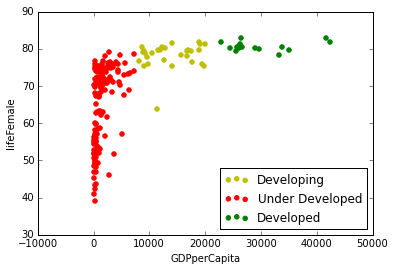

In [112]:
fig, ax = plt.subplots()
for clust in clust_map.values():
    color = d_color[clust]
    df[df.countrySegment == clust].plot(kind='scatter', x='GDPperCapita', y='lifeFemale', label=clust, ax=ax, color=color)
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc="lower right")

Similiarly trend for the females too